In [1]:
# @author Nikhil Maserang
# @date 2023/04/12

import numpy as np
import scipy.ndimage as spnd
import matplotlib.pyplot as plt
import cv2
import utils as ut

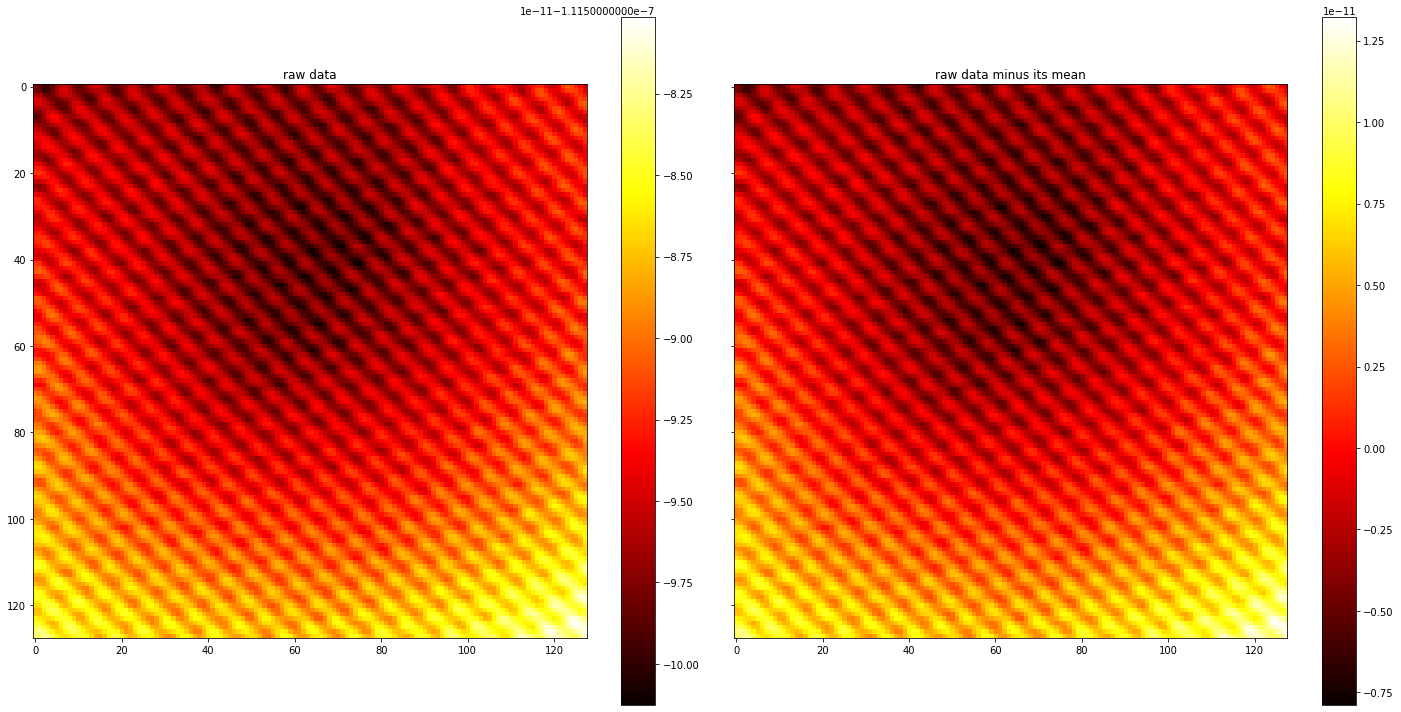

In [2]:
# get sxm data from file
fname = "testing.sxm"
data = ut.get_image_data(fname)

# remove the mean, 'centering' the data around 0;
# this is so the scalar FFT component doesn't mess up our results
centered_data = data - np.mean(data)

# plot
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20, 10), layout='tight')

plt.colorbar(axs[0].imshow(data, cmap="hot"), ax=axs[0])
plt.colorbar(axs[1].imshow(centered_data, cmap="hot"), ax=axs[1])

axs[0].set_title("raw data")
axs[1].set_title("raw data minus its mean")

plt.show()

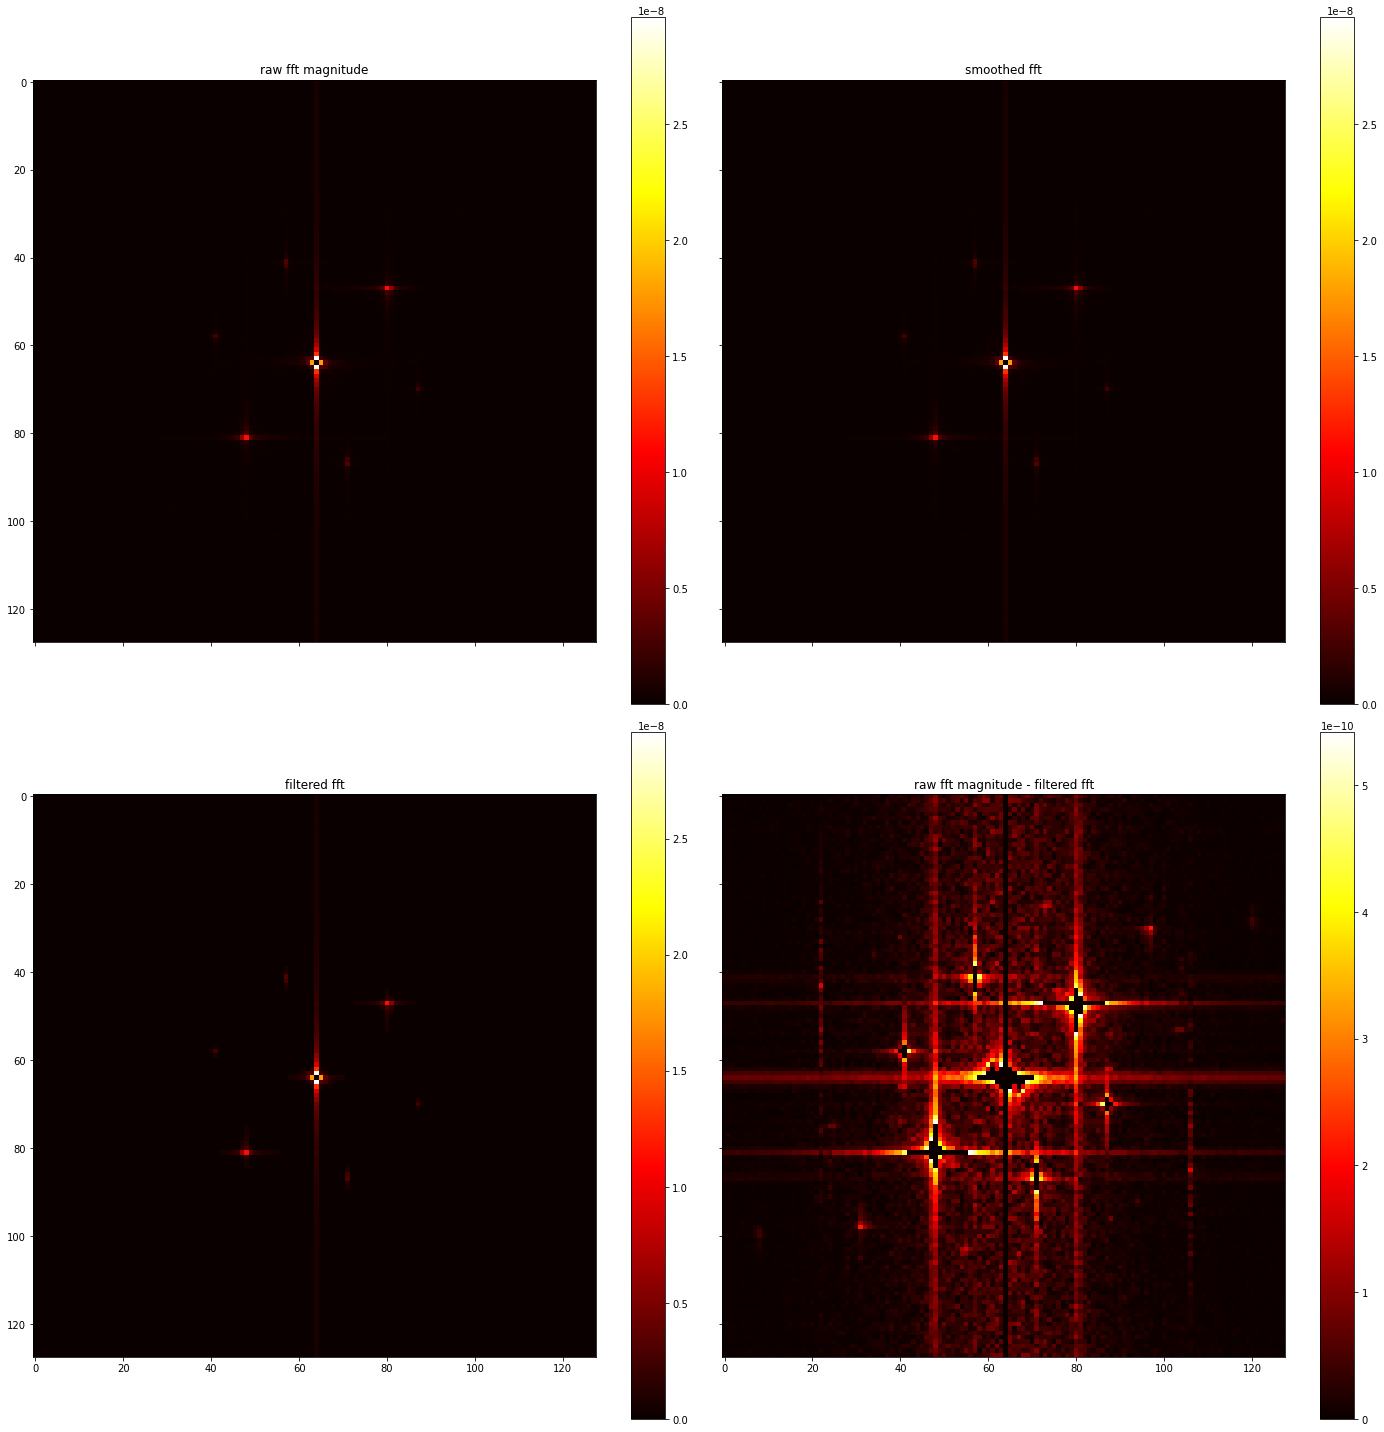

In [3]:
# perform shifted FFT on the data; output is complex but we care about magnitude, so we take abs
fft = np.abs(ut.run_shifted_fft(centered_data))

# perform Gaussian smoothing
smoothedfft = fft #spnd.gaussian_filter(fft, 0.5)

# filter out any data points under the average + stddev by setting them to 0
threshold = np.average(smoothedfft) + np.std(smoothedfft)
mask = (smoothedfft >= threshold)
filteredfft = mask * fft

# plot
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(20, 20), layout='tight')

plt.colorbar(axs[0, 0].imshow(fft, cmap='hot'), ax=axs[0, 0])
plt.colorbar(axs[0, 1].imshow(smoothedfft, cmap='hot'), ax=axs[0, 1])
plt.colorbar(axs[1, 0].imshow(filteredfft, cmap='hot'), ax=axs[1, 0])
plt.colorbar(axs[1, 1].imshow(fft - filteredfft, cmap='hot'), ax=axs[1, 1])

axs[0, 0].set_title("raw fft magnitude")
axs[0, 1].set_title("smoothed fft")
axs[1, 0].set_title("filtered fft")
axs[1, 1].set_title("raw fft magnitude - filtered fft")

plt.show()

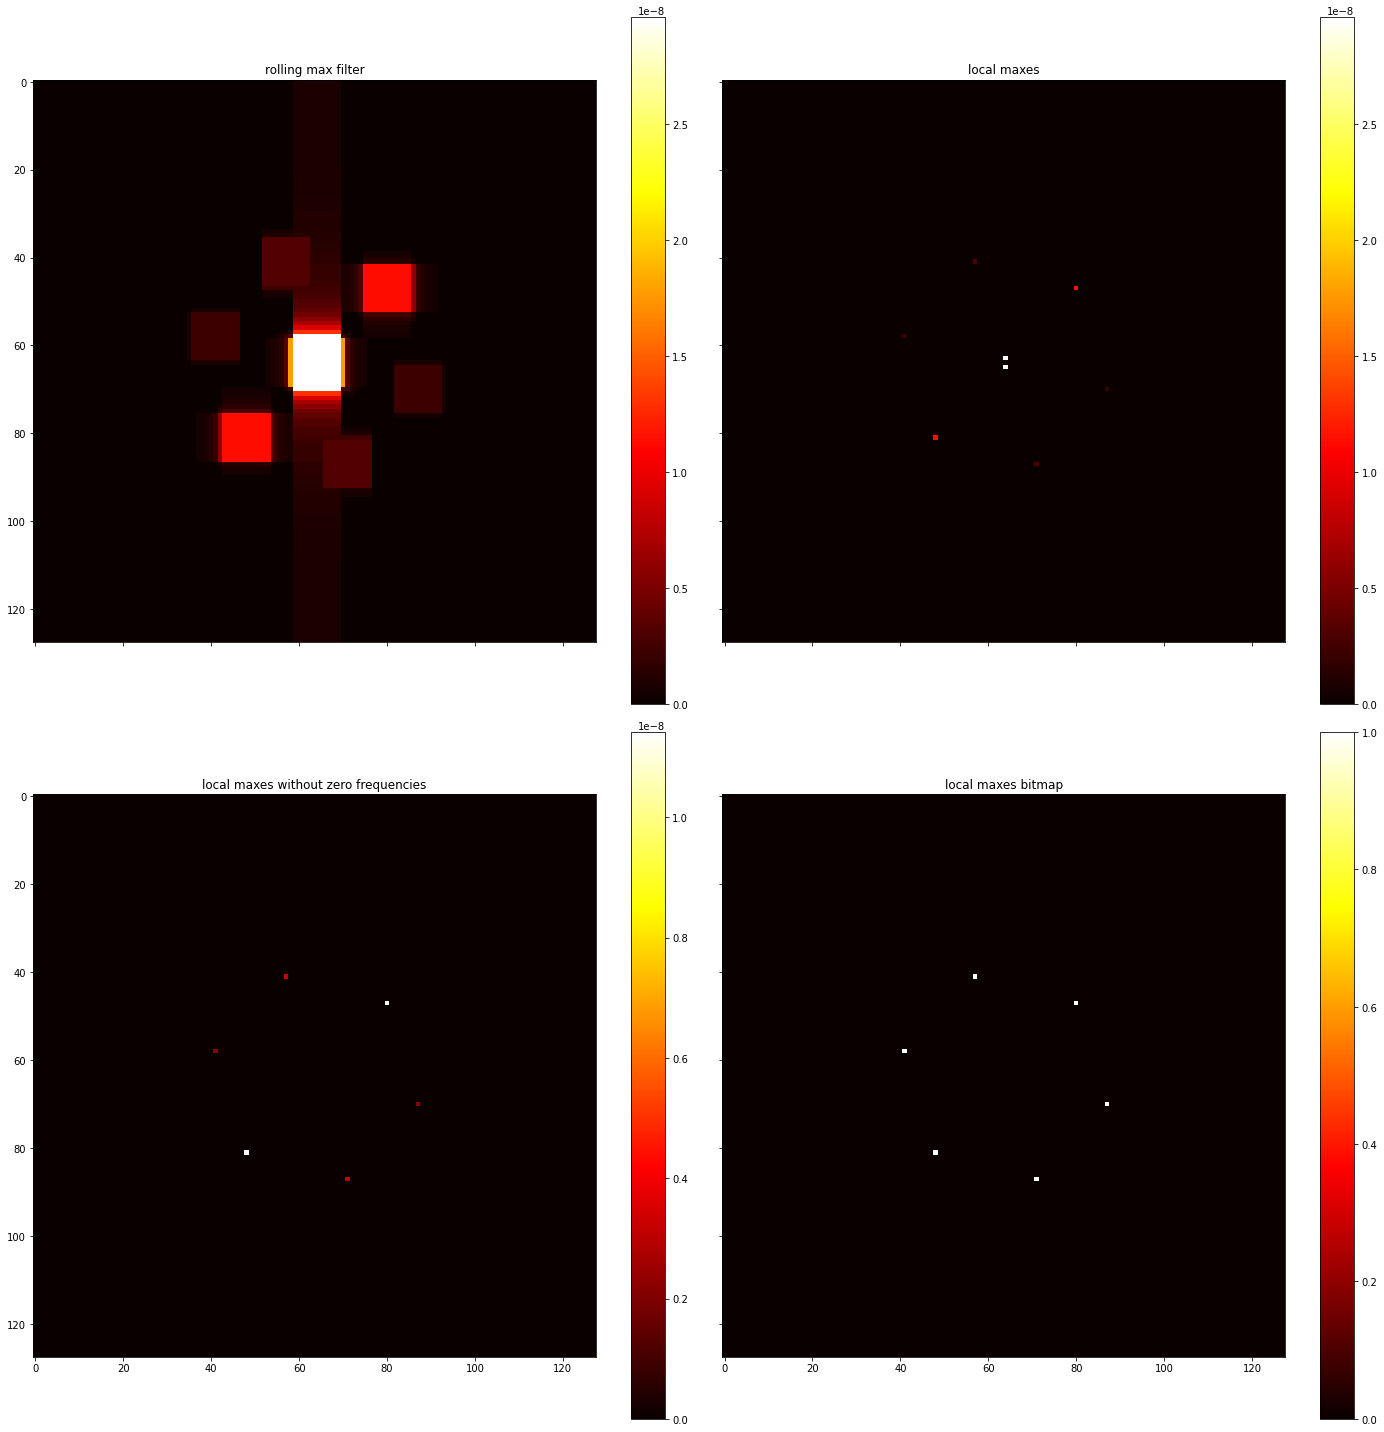

In [4]:
# compute a rolling maximum across the image
rolling_max = spnd.maximum_filter(filteredfft, 11)

# find points where local max has same value as point itself to get maxes
maxes = (rolling_max == filteredfft) * filteredfft

# blot out the middle to remove the extraneous points near 0
blotted_maxes = maxes.copy()
ut.blot_center(blotted_maxes, 5)

# get bitmap of nonzero matrix entries
maxes_bitmap = (blotted_maxes != 0)

# plot
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(20, 20), layout='tight')

plt.colorbar(axs[0, 0].imshow(rolling_max, cmap='hot'), ax=axs[0, 0])
plt.colorbar(axs[0, 1].imshow(maxes, cmap='hot'), ax=axs[0, 1])
plt.colorbar(axs[1, 0].imshow(blotted_maxes, cmap='hot'), ax=axs[1, 0])
plt.colorbar(axs[1, 1].imshow(maxes_bitmap, cmap='hot'), ax=axs[1, 1])

axs[0, 0].set_title("rolling max filter")
axs[0, 1].set_title("local maxes")
axs[1, 0].set_title("local maxes without zero frequencies")
axs[1, 1].set_title("local maxes bitmap")

plt.show()

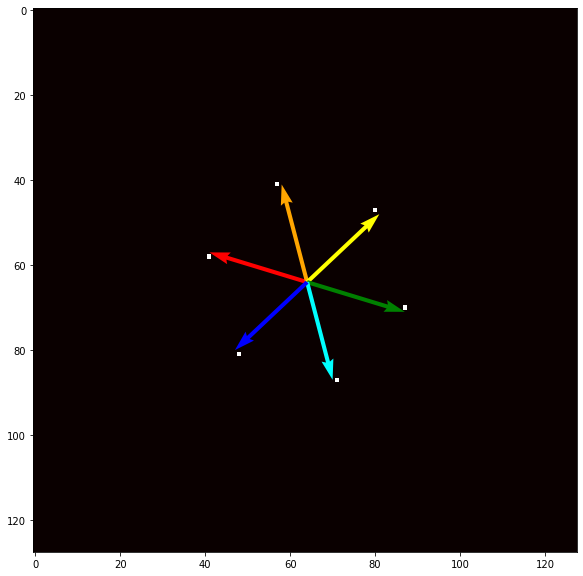

In [5]:
# get hexagon vertices and order them
vertices = np.array(np.nonzero(maxes_bitmap)).T
vertices = ut.order_vertices(vertices)

# get centroid and radial vectors
centroid = ut.centroid2D(vertices)
radial = vertices - centroid

# display radial vectors from centroid to vertices
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(maxes_bitmap, cmap="hot")

# need 6 copies of centroid, one per vector
x, y = np.resize(centroid, (6, 2)).T
u, v = radial.T
colors=['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'cyan']
quiver_props = dict(angles='xy', scale_units='xy', scale=1)
ax.quiver(x, y, u, v, **quiver_props, color=colors)

plt.show()


True


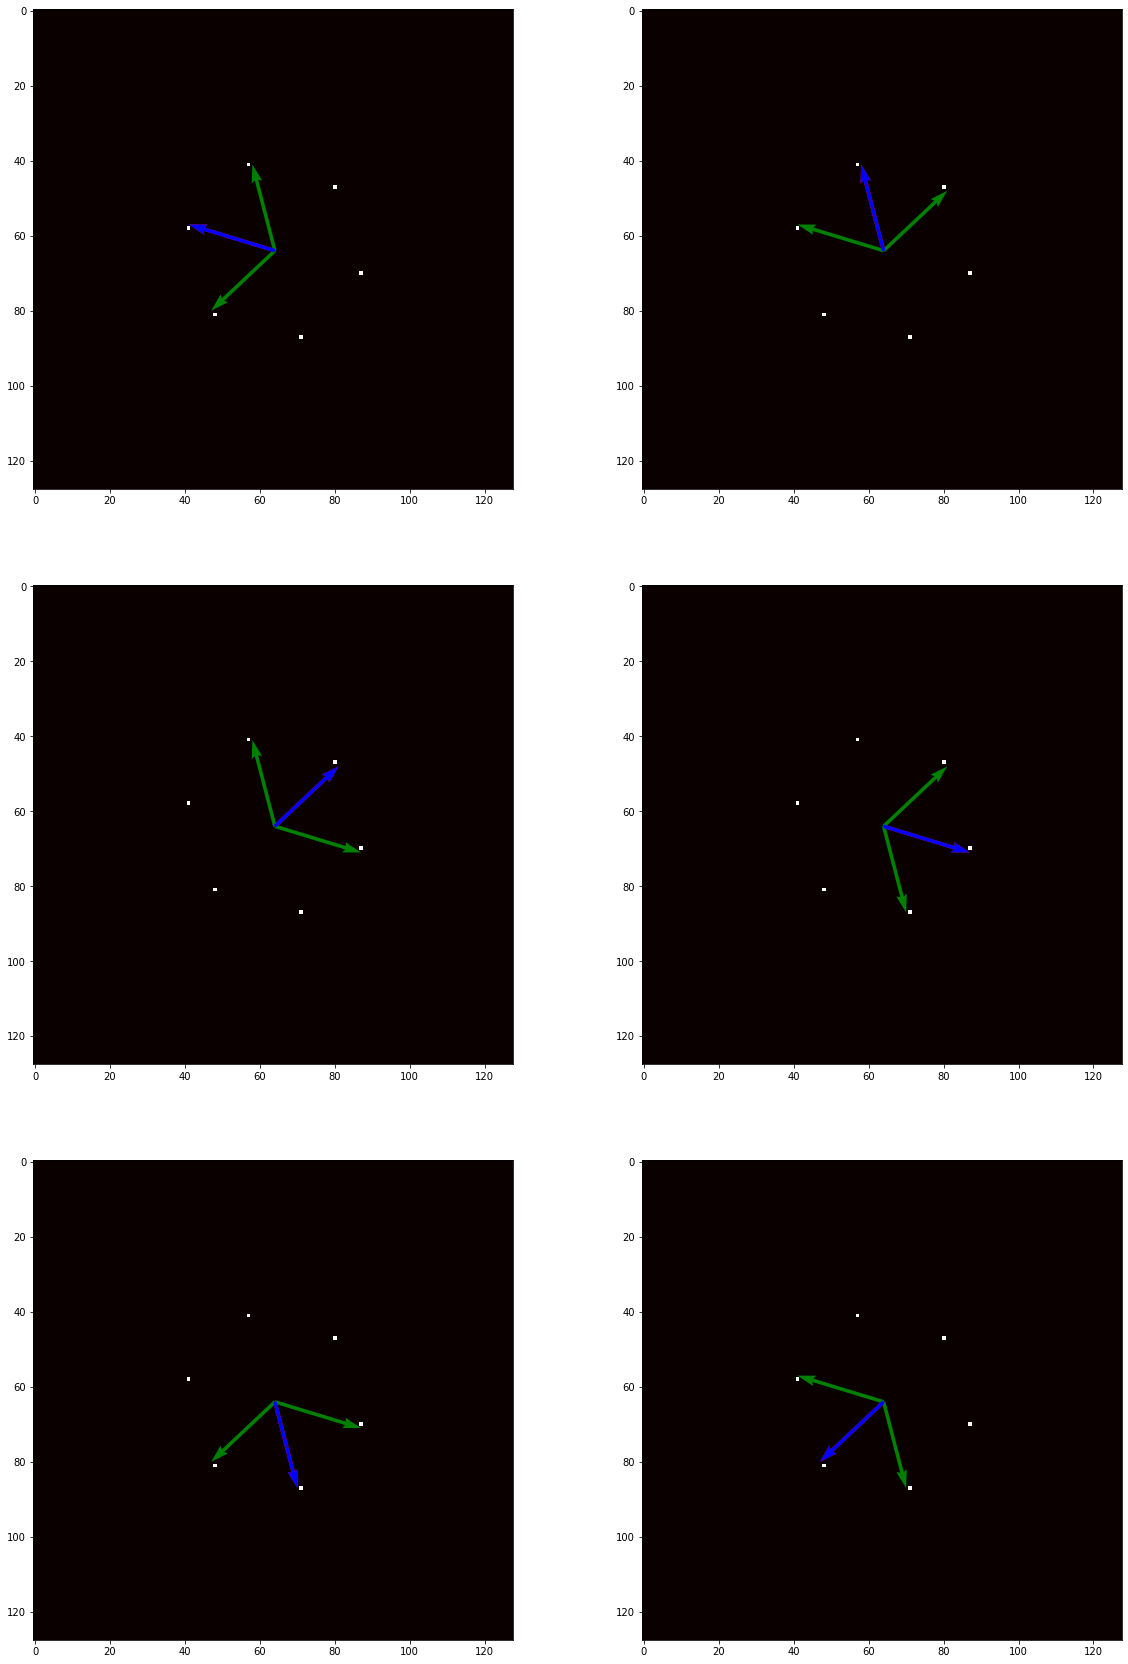

In [6]:
# verify that pairs of radial vectors sum to the vector in the middle
print(ut.verify_hexagon_shape(vertices, 1))

# plot to visualize the procedure

# roll vertices ahead and behind by 1, then sum
ahead = np.roll(radial, 1, axis=0)
behind = np.roll(radial, -1, axis=0)
vector_sum = ahead + behind

# create figure to show summations
fig, axs = plt.subplots(3, 2, figsize=(20, 30))
for ax in axs.flatten():
    ax.imshow(maxes_bitmap, cmap="hot")

# stack the sets of vectors so each individual axis 0 array contains corresponding vectors,
# then reshape to match shape of axs
V = np.stack([radial, ahead, behind, vector_sum], axis=1).reshape(3, 2, 4, 2)

# vector origin should be centroid; one copy needed per vector
x, y = np.resize(centroid, (4, 2)).T

# colors
colors = ["red", "green", "green", "blue"]

for r in range(3):
    for c in range(2):
        # V[r, c] contains the four vectors which need to be plotted
        axs[r, c].quiver(x, y, *V[r, c].T, **quiver_props, color=colors)

plt.show()

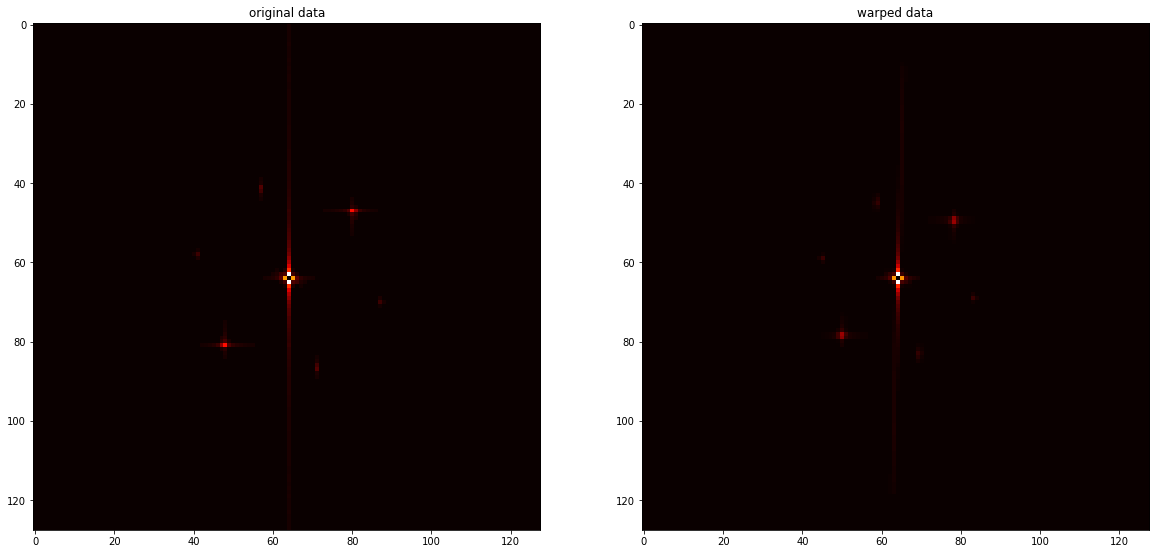

In [7]:
# transform the image
fixedfilteredfft = ut.transform_image(filteredfft, vertices, 20)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(filteredfft, cmap="hot")
axs[0].set_title("original data")

axs[1].imshow(fixedfilteredfft, cmap="hot")
axs[1].set_title("warped data")

plt.show()